In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import session_info
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import statsmodels.api as sm

In [4]:
try:
    session_info_output = session_info.show()
except Exception as error:
    print("The session info has been requested already:")
    
session_info_output

In [5]:
import janitor # This library generates an error when I execute session_info()

# Import external files

- Extension of the "missing" functions from Pandas
- DataFrame and dictionary functions
- Statistical functions

In [30]:
%run utils/u.0.0-pandas_missing_extension.ipynb
%run utils/u.0.1-df_functions.ipynb
%run utils/u.0.2-statistical-functions.ipynb

# Get the processed data (V3)

In [7]:
arg_di_df = pd.read_csv('../data/processed/WDICSV_PROCESSED_V3.csv').clean_names(case_type="snake")

print(arg_di_df.shape)
arg_di_df.info()

(54, 28)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ny_gdp_mktp_kd_zg_cat   54 non-null     float64
 1   sp_dyn_le00_in_cat      54 non-null     float64
 2   ny_gdp_pcap_kd_cat      54 non-null     float64
 3   se_sec_enrr_cat         54 non-null     float64
 4   ny_gdp_mktp_kd_grw_cat  54 non-null     float64
 5   it_cel_sets_cat         54 non-null     float64
 6   year                    54 non-null     float64
 7   it_mlt_main             54 non-null     float64
 8   ny_gdp_mktp_kd_zg       54 non-null     float64
 9   ny_gdp_pcap_kd          54 non-null     float64
 10  ny_gdp_pcap_kd_zg       54 non-null     float64
 11  sp_dyn_le00_in          53 non-null     float64
 12  it_cel_sets             54 non-null     float64
 13  sh_dth_imrt             53 non-null     float64
 14  sp_pop_0014_to_zs       54 non-null

# Get columns names and types

In [32]:
indicators_names, categorical_cols, numeric_cols, columns_with_missing_values = get_columns(arg_di_df, True)

In [33]:
print(f'Total Columns: {len(indicators_names)}')
print(f'Categorical Columns: {len(categorical_cols)}')
print(f'Numeric Columns: {len(numeric_cols)}')

Total Columns: 28
Categorical Columns: 7
Numeric Columns: 21


In [23]:
arg_di_df.dtypes

ny_gdp_mktp_kd_zg_cat     float64
sp_dyn_le00_in_cat        float64
ny_gdp_pcap_kd_cat        float64
se_sec_enrr_cat           float64
ny_gdp_mktp_kd_grw_cat    float64
it_cel_sets_cat           float64
year                      float64
it_mlt_main               float64
ny_gdp_mktp_kd_zg         float64
ny_gdp_pcap_kd            float64
ny_gdp_pcap_kd_zg         float64
sp_dyn_le00_in            float64
it_cel_sets               float64
sh_dth_imrt               float64
sp_pop_0014_to_zs         float64
sp_pop_1564_to_zs         float64
sp_pop_65_up_to_zs        float64
sp_pop_totl               float64
sm_pop_refg               float64
sm_pop_refg_or            float64
se_pre_enrr               float64
se_prm_enrr               float64
se_sec_enrr               float64
se_ter_enrr               float64
sp_urb_totl_in_zs         float64
year_of_dictatorship      float64
it_cel_sets_pct           float64
dem_dep_cat               float64
dtype: object

In [10]:
indicators_names

['ny_gdp_mktp_kd_zg_cat, GDP growth categories',
 'sp_dyn_le00_in_cat, Life Expectancy categories',
 'ny_gdp_pcap_kd_cat, GDP Per Capita Categories',
 'se_sec_enrr_cat, Secondary school enrollment categories',
 'ny_gdp_mktp_kd_grw_cat, GDP Growth Volatility',
 'it_cel_sets_cat, Mobile Subscription Categories',
 'year, Year',
 'it_mlt_main, Fixed telephone subscriptions',
 'ny_gdp_mktp_kd_zg, GDP growth (annual %)',
 'ny_gdp_pcap_kd, GDP per capita (constant 2015 US$)',
 'ny_gdp_pcap_kd_zg, GDP per capita growth (annual %)',
 'sp_dyn_le00_in, Life expectancy at birth, total (years)',
 'it_cel_sets, Mobile cellular subscriptions',
 'sh_dth_imrt, Number of infant deaths',
 'sp_pop_0014_to_zs, Population ages 0-14 (% of total population)',
 'sp_pop_1564_to_zs, Population ages 15-64 (% of total population)',
 'sp_pop_65_up_to_zs, Population ages 65 and above (% of total population)',
 'sp_pop_totl, Population, total',
 'sm_pop_refg, Refugee population by country or territory of asylum',
 's

In [11]:
columns_with_missing_values

['se_ter_enrr',
 'sm_pop_refg_or',
 'se_pre_enrr',
 'se_prm_enrr',
 'se_sec_enrr',
 'sp_dyn_le00_in',
 'sh_dth_imrt']

# Split target variable

Target variable: sp_dyn_le00_in (Life expectancy at birth, total (years))

In [12]:
target_variable = "sp_dyn_le00_in"
target_variable_name = get_indicator_name(target_variable, True)

In [ ]:
if target_variable in numeric_cols:
    numeric_cols.remove(target_variable)

## Split rows with missing values in the target variable

In [13]:
rows_with_na = arg_di_df[arg_di_df[target_variable].isna()].copy()
rows_with_na

,ny_gdp_mktp_kd_zg_cat,sp_dyn_le00_in_cat,ny_gdp_pcap_kd_cat,se_sec_enrr_cat,ny_gdp_mktp_kd_grw_cat,it_cel_sets_cat,year,it_mlt_main,ny_gdp_mktp_kd_zg,ny_gdp_pcap_kd,...,sm_pop_refg,sm_pop_refg_or,se_pre_enrr,se_prm_enrr,se_sec_enrr,se_ter_enrr,sp_urb_totl_in_zs,year_of_dictatorship,it_cel_sets_pct,dem_dep_cat
53,1.0,0.0,3.0,0.0,1.0,4.0,1.0,0.647369,0.432342,0.739951,...,0.041237,0.232682,NaN,NaN,NaN,NaN,1.0,0.0,0.841504,0.0


In [51]:
X = arg_di_df.drop(index=rows_with_na.index)[numeric_cols]
y = arg_di_df.drop(index=rows_with_na.index)[target_variable]

X.shape, y.shape

((53, 20), (53,))

# Impute missing values

MICE (Multiple Imputation by Chained Equations) is a technique for imputing missing data, where multiple possible values are generated for each missing entry using iterative regression models.

If dependent variables have NA values, then linear regression will predict NA results

In [131]:
mice_imputer = IterativeImputer(estimator=Ridge())

X_mice = pd.DataFrame(mice_imputer.fit_transform(X), columns=numeric_cols, index=arg_di_df.drop(index=rows_with_na.index).index)

In [132]:
print("Check missing values in all columns")
X_mice.isna().sum().sum()

Check missing values in all columns


0

# Apply Linear Regression

## Get predictions

In [ ]:
def apply_linear_regression(X):

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('X_train shape: ', X_train.shape )
    print('X_test shape: ', X_test.shape )
    print('y_train shape: ', y_train.shape)
    print('y_test shape: ', y_test.shape)

    # Model training
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    #Evaluate the model
    print('Main metrics')
    print('mse', round(metrics.mean_squared_error(y_test, y_pred),4))
    print('r2', round(metrics.r2_score(y_test, y_pred),2))

    #Model summary
    y_pred.reshape(-1)
    X_test_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_test, X_test_sm).fit()
    print(model_sm.summary())
    
    #Plot Linear Regression Residuals
    residuals = np.subtract(y_test, y_pred.reshape(-1))
    title = "Linear Regression Residuals"
    sns.scatterplot(x=y_pred, y=residuals)
    plt.title(title)
    plt.ylabel("")
    plt.show()

# Evaluate the model

X_train shape:  (42, 20)
X_test shape:  (11, 20)
y_train shape:  (42,)
y_test shape:  (11,)
Main metrics
mse 0.0007
r2 0.99
                            OLS Regression Results                            
Dep. Variable:         sp_dyn_le00_in   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 19 Jul 2025   Prob (F-statistic):                nan
Time:                        15:08:53   Log-Likelihood:                 361.50
No. Observations:                  11   AIC:                            -701.0
Df Residuals:                       0   BIC:                            -696.6
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.97

/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.d

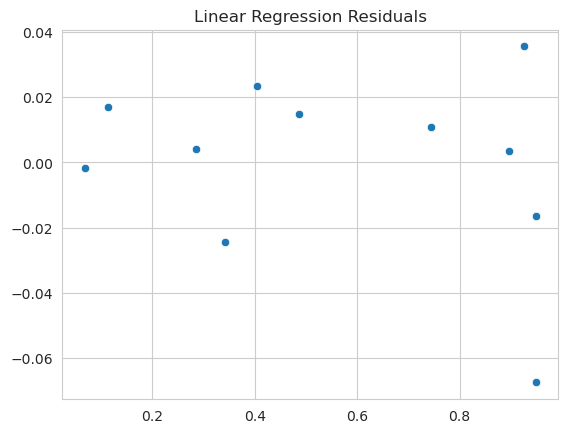

In [137]:
apply_linear_regression(X_mice)

## Check correlation between variables for enhance the model

<Axes: >

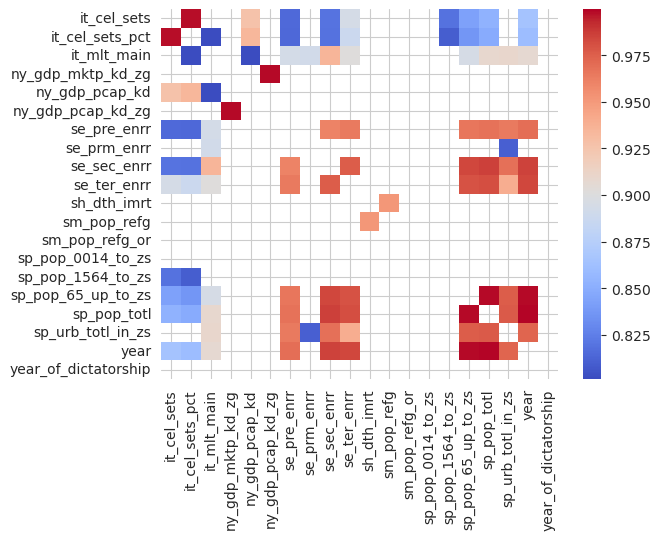

In [138]:
corr_matrix = arg_di_df[sorted(numeric_cols)].corr()
high_corr_matrix = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1)]
sns.heatmap(data=high_corr_matrix, cmap='coolwarm')

### Remove columns

<Axes: >

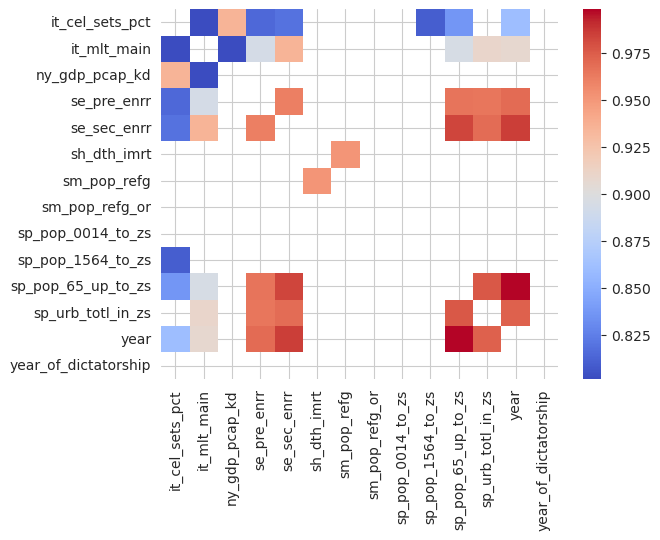

In [139]:
numeric_cols_2 = [col for col in numeric_cols if col not in ['it_cel_sets','sp_pop_totl','se_prm_enrr','se_ter_enrr','ny_gdp_pcap_kd_zg','ny_gdp_mktp_kd_zg']]

corr_matrix = arg_di_df[sorted(numeric_cols_2)].corr()
high_corr_matrix = corr_matrix[(corr_matrix > 0.8) & (corr_matrix < 1)]
sns.heatmap(data=high_corr_matrix, cmap='coolwarm')

X_train shape:  (42, 14)
X_test shape:  (11, 14)
y_train shape:  (42,)
y_test shape:  (11,)
Main metrics
mse 0.0004
r2 1.0
                            OLS Regression Results                            
Dep. Variable:         sp_dyn_le00_in   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 19 Jul 2025   Prob (F-statistic):                nan
Time:                        15:13:02   Log-Likelihood:                 357.05
No. Observations:                  11   AIC:                            -692.1
Df Residuals:                       0   BIC:                            -687.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975

/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=11 observations were given.
  return hypotest_fun_in(*args, **kwds)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: invalid value encountered in scalar multiply
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/ubuntu/anaconda3/envs/research-on-argentina/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.d

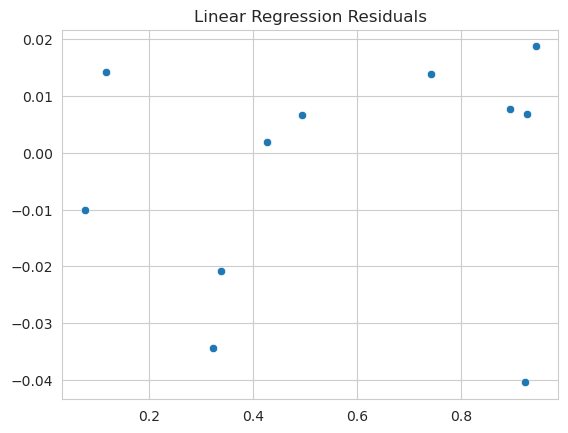

In [145]:
X_mice_2 = X_mice[numeric_cols_2]
apply_linear_regression(X_mice_2)

### Get only 3 variables to apply the model

<Axes: >

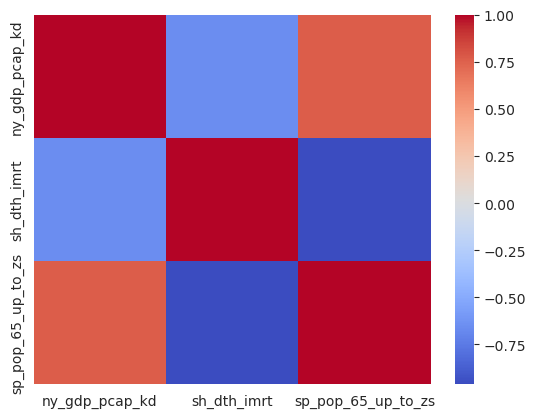

In [153]:
numeric_cols_3 = ['ny_gdp_pcap_kd', 'sp_pop_65_up_to_zs', 'sh_dth_imrt']
corr_matrix = arg_di_df[sorted(numeric_cols_3)].corr()
sns.heatmap(data=corr_matrix, cmap='coolwarm')
# apply_linear_regression(X_mice_2)

In [ ]:
#TODO: detect dependent variables
#TODO: What does this code lines do? (From 02-multivariable-linear... of the other reporsitory)
# pred = slr.predict(plane.values).reshape(X1.shape)
# pred = sc_y.inverse_transform(pred)
#TODO: Summary interpretation
#TOOD: Iterate only with variables that it's value is close to 0
#TODO: Linear regression analysis